---
---

<h1>Notebook: [ Week #04: Building your own RAG Bot ]</h1>

- Your objective in this notebook is create a RAG Bot that allow the users to interact with some notes from AI Champions Bootcamp.
- A convenient way to work on this notebook is to open the earlier Jupyter Notebook in `Topic 4`. Yes, the notebook with pre-populated code cells.
- You can refer to how a simple RAG Bot (or more like a RAG pipeline) is built
- You may extend the functionalities of the bot as you wish.
- Minimumly, you should have a simple RAG Bot like the one in the earlier `Topic 4` Jupyter Notebook


---
---

# Setup

In [1]:
!pip install openai
!pip install langchain
!pip install langchain-openai
!pip install langchain-experimental
!pip install langchain-chroma
!pip install pypdf
!pip install lolviz
!pip install chromadb
!pip install tqdm
!pip install tiktoken

# You may need to install other dependencies that you need for your project

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.2/396.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
import os
import openai
from getpass import getpass

# Set up the OpenAI API key by setting the OPENAI_API_KEY environment variable
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API Key")


Enter your OpenAI API Key··········


---

## Helper Functions

---

### Function for Generating Embedding

In [3]:
def get_embedding(input, model='text-embedding-3-small'):
    response = client.embeddings.create(
        input=input,
        model=model
    )
    return [x.embedding for x in response.data]

### Function for Text Generation

In [4]:
# This is the "Updated" helper function for calling LLM
def get_completion(prompt, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=256, n=1, json_output=False):
    if json_output == True:
      output_json_structure = {"type": "json_object"}
    else:
      output_json_structure = None

    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create( #originally was openai.chat.completions
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1,
        response_format=output_json_structure,
    )
    return response.choices[0].message.content

In [5]:
# This a "modified" helper function that we will discuss in this session
# Note that this function directly take in "messages" as the parameter.
def get_completion_by_messages(messages, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=1024, n=1):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1
    )
    return response.choices[0].message.content

## Functions for Token Counting

In [6]:
# These functions are for calculating the tokens.
# ⚠️ These are simplified implementations that are good enough for a rough estimation.

import tiktoken

def count_tokens(text):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    return len(encoding.encode(text))

def count_tokens_from_message(messages):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    value = ' '.join([x.get('content') for x in messages])
    return len(encoding.encode(value))


---
---

# Create a "Chat with your Document" Bot

**\[ Overview of Steps in RAG \]**

- 1. **Document Loading**
	- In this initial step, relevant documents are ingested and prepared for further processing. This process typically occurs offline.
- 2. **Splitting & Chunking**
	- The text from the documents is split into smaller chunks or segments.
	- These chunks serve as the building blocks for subsequent stages.
- 3. **Storage**
	- The embeddings (vector representations) of these chunks are created and stored in a vector store.
	- These embeddings capture the semantic meaning of the text.
- 4. **Retrieval**
	- When an online query arrives, the system retrieves relevant chunks from the vector store based on the query.
	- This retrieval step ensures that the system identifies the most pertinent information.
- 5. **Output**
	- Finally, the retrieved chunks are used to generate a coherent response.
	- This output can be in the form of natural language text, summaries, or other relevant content.

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-overview.png)

---
---

## Document Loading

Here are the "notes" that you must include in your RAG pipeline as the `Documents`
- [Key Parameters for LLMs](https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html)
- [LLMs and Hallucinations](https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/3.-llms-and-hallucinations.html)
- [Prompting Techniques for BUilders](https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/4.-prompting-techniques-for-builders.html)

You have three options.
1) 💪🏼 Take up the challenge to find a way to get the content directly from the webpages above.
2) 🥴 Go with the easy route, download the notes nicely prepared in a `.txt` format. Download the zipped file [here](https://abc-notes.data.tech.gov.sg/resources/data/notes.zip)
3) 😎 “Only children choose; adults take all.” Experiment with both data sources and see which can help to the Bot to provide more accurate information for the user queries.

---

> 💡 **Feel free to add as many code cells as your need.**

---

In [7]:
#install langchain beautiful soup
!pip install langchain beautifulsoup4

In [8]:
import requests
from bs4 import BeautifulSoup
from langchain.schema import Document

url1 =  "https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html"
url2 = "https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/3.-llms-and-hallucinations.html"
url3 = "https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/4.-prompting-techniques-for-builders.html"

urls = [
    url1,
    url2,
    url3
]

docs = []

In [9]:
for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.get_text()
    docs.append(Document(page_content=text, metadata={'source': url}))

docs

[Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html'}, page_content=' \n2. Key Parameters for LLMs\n\n\n\n\n\n\n\n\n\n\n\nicon: LiNotebookTabsCopyTitle: Key Parameters for LLMs\n\nTokens\nKey Parameters for LLM\nLLMs and Hallucination\nPrompting Techniques for Builders\nHands-on Walkthrough and Tasks\nKey Parameters for LLMs\n✦ For our Helper Function in the notebook, we only pass in three arguments to the create() method.\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\nCopy\n✦ The method can accept more parameters than we are using here.\n✦ There are three essential para

## Splitting & Chunking

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Note that in this example, we pass the `count_tokens` function as the `length_function` parameter
#The text_splitter will use the `count_tokens` function to calculate the length of the text (in tokens)
# instead of the number of characters (default behavior).

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=30,
    length_function=count_tokens
)

In [11]:
splitted_documents = text_splitter.split_documents(docs)

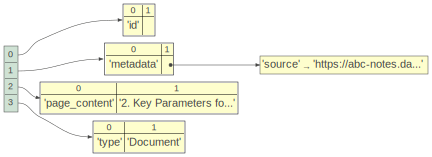

In [12]:
import lolviz
# Display the first splitted document
lolviz.objviz(splitted_documents[0])

In [13]:
# Show the number of tokens in each of the splitted documents
for doc in splitted_documents:
    print(count_tokens(doc.page_content))

271
288
274
264
295
298
263
252
292
248
238
268
273
208
281
46
289
248
237
282
264
292
295
285
266
270
252
225


In [14]:
splitted_documents[15]

Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/4.-prompting-techniques-for-builders.html'}, page_content="# Append a string to the file\n    file.write('\\nHello again!')\nCopyJSON\n✦ JSON (JavaScript Object Notation) is a lightweight data interchange format commonly used for structuring and transmitting data between systems.")

In [15]:
splitted_documents[16]

Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/4.-prompting-techniques-for-builders.html'}, page_content='It is human-readable and easy for both humans and machines to understand. In JSON, data is organized into key-value pairs, making it ideal for representing complex data structures.\nIt is widely used in web APIs, configuration files, and data storage due to its simplicity and versatility.\nMost APIs return the data in JSON format (e.g., data.gov.sg, Telegram\'s API)\n\n\nWhile JSON is very similar to Python\'s dictionary, a key difference to remember is:\n\n✦ JSON keys MUST be strings enclosed in double quotation marks ("key").\n✦ in JSON, both the keys and values CANNOT be enclosed in single quotation marks (e.g., ❌ \'Ang Mo Kio\')\n✦ Dictionary keys can be any hashable object (not restricted to strings). Don\'y worry if you do not understand this line as it\'s not critical.\n\nReading and Parsing JSON File\n✦ In the cell below

## Storage: Embedding & Vectorstores

In [16]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# An embeddings model is initialized using the OpenAIEmbeddings class.
# The specified model is 'text-embedding-3-small'.
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

# For more info on using the Chroma class, refer to the documentation https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/
vector_store = Chroma.from_documents(
    collection_name="prompt_engineering_playbook",
    documents=splitted_documents,
    embedding=embeddings_model,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not neccesary
)

In [17]:
# Show the number of documents in the vector store
vector_store._collection.count()

28

In [18]:
# Peek at one of the documents in the vector store
vector_store._collection.peek(limit=1)

{'ids': ['13e9c558-3b33-478f-98ab-cf32cf3bf0a3'],
 'embeddings': [[0.017449667677283287,
   -0.03646901994943619,
   0.011301734484732151,
   -0.04656733199954033,
   -0.0289606936275959,
   -0.02066752314567566,
   0.0030085635371506214,
   0.03916364908218384,
   0.019961165264248848,
   0.031132090836763382,
   -0.03955606743693352,
   -0.026030614972114563,
   -0.050988610833883286,
   -0.02992866560816765,
   -0.05159032344818115,
   -0.030922800302505493,
   -0.00977129116654396,
   0.02281275950372219,
   0.005974614527076483,
   0.04311402142047882,
   -0.01666482537984848,
   0.010085227899253368,
   -0.01790749281644821,
   0.027260201051831245,
   0.015055897645652294,
   -0.018038300797343254,
   -0.020772168412804604,
   0.021073024719953537,
   0.010176792740821838,
   -0.032623291015625,
   0.02956240624189377,
   -0.025468144565820694,
   -0.054991308599710464,
   -0.0017413696041330695,
   -0.03165531903505325,
   0.009084553457796574,
   0.03322500362992287,
   0.0182

In [19]:
# How to load the vector store from the disk
vector_store = Chroma("prompt_engineering_playbook",
                      embedding_function=embeddings_model,
                      persist_directory= "./chroma_langchain_db")

## Retrieval

In [20]:
vector_store.similarity_search('Zero Shot', k=3)

[Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html'}, page_content="Try out in notebook week 02\nThe live calculation to show the intuition of the Top-K process is included in the Notebook of this week. Try it out!\nTop-P\n✦ Top-P is also known as nucleus sampling\n\nThis is an alternative to Top-K sampling, which we will discuss next.\nInstead of selecting the top K most probable words, it selects the smallest set of words whose cumulative probability exceeds a threshold P. Then it samples the next word from this set.\nTop-P sampling gives us a subset of words whose cumulative probability exceeds a certain threshold (P), making it a useful method for narrowing down a list of candidates based on their probabilities.\n\n\nIn practice, either Top-K or Top-P is used, but not both at the same time. They are different strategies for controlling the trade-off between diversity and confidence in the model’s pre

In [21]:
vector_store.similarity_search_with_relevance_scores('Zero Shot', k=3)


<ipython-input-21-ce0c9eea9ebb>:1: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html'}, page_content="Try out in notebook week 02\nThe live calculation to show the intuition of the Top-K process is included in the Notebook of this week. Try it out!\nTop-P\n✦ Top-P is also known as nucleus sampling\n\nThis is an alternative to Top-K sampling, which we will discuss next.\nInstead of selecting the top K most probable words, it selects the smallest set of words whose cumulative probability exceeds a threshold P. Then it samples the next word from this set.\nTop-P sampling gives us a subset of words whose cumulative probability exceeds a certain threshold (P), making it a useful method for narrowing down a list of candidates based on their probabilities.\n\n\nIn practice, either Top-K or Top-P is used, but not both at the same time. They are differe

[(Document(metadata={'source': 'https://abc-notes.data.tech.gov.sg/notes/topic-2-deeper-dive-into-llms/2.-key-parameters-for-llms.html'}, page_content="Try out in notebook week 02\nThe live calculation to show the intuition of the Top-K process is included in the Notebook of this week. Try it out!\nTop-P\n✦ Top-P is also known as nucleus sampling\n\nThis is an alternative to Top-K sampling, which we will discuss next.\nInstead of selecting the top K most probable words, it selects the smallest set of words whose cumulative probability exceeds a threshold P. Then it samples the next word from this set.\nTop-P sampling gives us a subset of words whose cumulative probability exceeds a certain threshold (P), making it a useful method for narrowing down a list of candidates based on their probabilities.\n\n\nIn practice, either Top-K or Top-P is used, but not both at the same time. They are different strategies for controlling the trade-off between diversity and confidence in the model’s pr

## Question & Answer

In [22]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

In [24]:
qa_chain = RetrievalQA.from_chain_type(
    ChatOpenAI(model='gpt-4o-mini'),
    retriever=vector_store.as_retriever(k=20)
)

qa_chain.invoke("Why should use temperature and top_p?")

{'query': 'Why should use temperature and top_p?',
 'result': "Temperature and top-p are used to control the diversity and creativity of the responses generated by language models. \n\n1. **Temperature**: This parameter adjusts the randomness of the model's predictions. \n   - A high temperature (e.g., 0.7 or higher) leads to more varied and creative outputs, allowing for unexpected and diverse responses. This is useful in scenarios like creative writing or brainstorming.\n   - A low temperature (e.g., 0.2 or lower) results in more predictable and conservative outputs, favoring the most likely responses. This is beneficial for tasks that require accuracy and adherence to established patterns, such as code generation.\n\n2. **Top-p (nucleus sampling)**: This method allows for a more dynamic selection of possible next words. Instead of fixing a number of top choices (like in top-k sampling), top-p selects the smallest set of words whose cumulative probability exceeds a certain threshold 